In [83]:
# get github access token for collab
import getpass
token = getpass.getpass()

··········


In [87]:
# clean workdir
%cd /content/
%rm -r /content/*
%ls -la
%pwd

/content
total 16
drwxr-xr-x 1 root root 4096 Jul 19 12:30 ./
drwxr-xr-x 1 root root 4096 Jul 19 11:09 ../
drwxr-xr-x 4 root root 4096 Jul 17 13:23 .config/


'/content'

In [88]:

# clone github repo
!git clone https://{token}@github.com/marendtz/ResearchArxivACM.git

Cloning into 'ResearchArxivACM'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 56 (delta 19), reused 51 (delta 15), pack-reused 0
Receiving objects: 100% (56/56), 1.45 MiB | 5.21 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:

# get python version if needed
!sudo apt-get install -y software-properties-common
!sudo add-apt-repository -y ppa:deadsnakes/ppa
!sudo apt-get update
!sudo apt-get install -y python3.11

In [89]:
# install dependencies
!pip install -r /content/ResearchArxivACM/requirements_collab.txt

In [90]:
import json
import re

import torch
import umap
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup


import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS


In [91]:
# Load Dataframe from Excel
df = pd.read_excel("/content/ResearchArxivACM/analysis/intermediate/merged_df.xlsx")

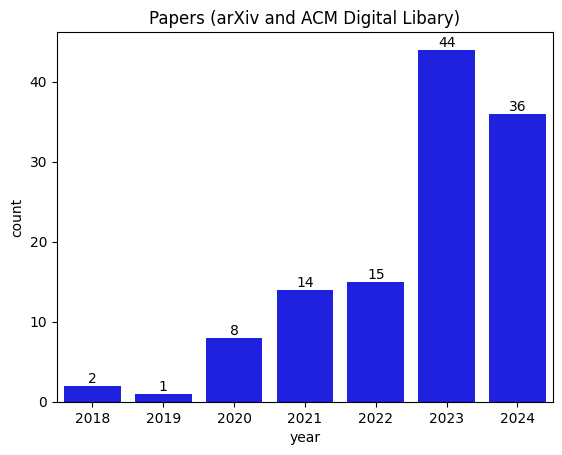

<Figure size 640x480 with 0 Axes>

In [93]:
# Explorative Data Analysis
ax = sns.countplot(data=df, x='year',color="blue")
ax.bar_label(ax.containers[0])
plt.title("Papers (arXiv and ACM Digital Libary)")
# Show the plot
plt.show()
# Save seaborn plot as image
plt.savefig('/content/ResearchArxivACM/analysis/out/pub_per_year_simple.png', dpi=300)

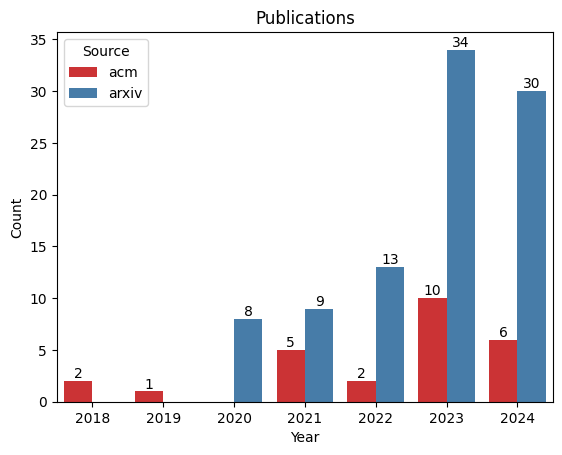

<Figure size 640x480 with 0 Axes>

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the necessary columns
ax = sns.countplot(data=df, x='year', hue='source', palette='Set1')

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

plt.title("Publications")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title='Source')
# Show the plot
plt.show()
# Save the seaborn plot as an image
plt.savefig('/content/ResearchArxivACM/analysis/out/pub_per_year_advanced.png', dpi=300)

In [97]:
# Filter 2018-2023
df = df[df['year'] >= 2018]
# Dataframe to Excel
df.to_excel("/content/ResearchArxivACM/analysis/out/merged_filtered_df.xlsx")

# Safe Dataframe to pickle
df.to_pickle("/content/ResearchArxivACM/analysis/out/merged_filtered_df.pkl")

In [98]:
df.shape

(120, 6)

In [99]:
# Set device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Should say cuda:0
device

# Extract abstracts
abstracts = df.abstract.tolist()

# Load the transformer model
# e.g. sentence-transformers/allenai-specter
# SOTA from https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model = model.to(device)

# Create the embeddings
embeddings = model.encode(abstracts)
embeddings
embeddings.shape


(120, 768)

In [ ]:
# Setup the UMAP see: https://pair-code.github.io/understanding-umap/
# n_neighbors: low values will push UMAP to focus more on local structure by constraining the number of neighboring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail
reducer = umap.UMAP(n_neighbors=5,
                    n_components=3,
                    n_jobs = -1)
embedding_3d = reducer.fit_transform(embeddings)
embedding_3d[:, 0]


In [100]:
# Put into Dataframe
df["abstract_vector_d1"] = embedding_3d[:, 0]
df["abstract_vector_d2"] = embedding_3d[:, 1]
df["abstract_vector_d3"] = embedding_3d[:, 2]
df.head()


,Unnamed: 0,title,abstract,authors,year,source,abstract_vector_d1,abstract_vector_d2,abstract_vector_d3
0,0,Learning Local Neighboring Structure for Robus...,Mesh is a powerful data structure for 3D sha...,"Zhongpai Gao, Junchi Yan, Guangtao Zhai, Juyon...",2020,arxiv,5.847734,10.907460,6.112492
1,1,Permutation Matters: Anisotropic Convolutional...,It has witnessed a growing demand for effici...,"Zhongpai Gao, Guangtao Zhai, Junchi Yan, Xiaok...",2020,arxiv,5.903154,11.003589,5.999220
2,2,CNRL at SemEval-2020 Task 5: Modelling Causal ...,"In this paper, we describe an approach for m...",Rajaswa Patil and Veeky Baths,2020,arxiv,1.902914,8.013249,5.941692
3,3,Learning Joint Spatial-Temporal Transformation...,High-quality video inpainting that completes...,"Yanhong Zeng, Jianlong Fu, Hongyang Chao",2020,arxiv,4.185503,9.365823,5.535667
4,4,Social Commonsense Reasoning with Multi-Head K...,Social Commonsense Reasoning requires unders...,Debjit Paul and Anette Frank,2020,arxiv,2.034648,8.548445,6.157651


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1080: UserWarning:

Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.



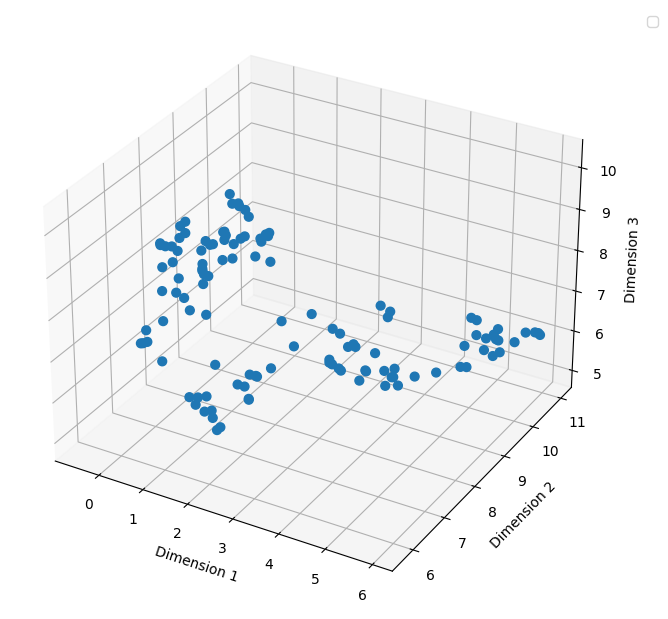

In [112]:
# Vizualize
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df["abstract_vector_d1"],
                df["abstract_vector_d2"],
                df["abstract_vector_d3"],
                s=40,
                #c=df["abstract_vector_d4"],
                marker='o',
                #cmap=cmap,
                alpha=1)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

# Save seaborn plot as image
plt.savefig('/content/ResearchArxivACM/analysis/out/abstracts_seaborn.png', dpi=300)

In [105]:
import plotly.express as px
fig = px.scatter_3d(df,
                    x="abstract_vector_d1",
                    y="abstract_vector_d2",
                    z="abstract_vector_d3",
                    #color="abstract_vector_d4",
                    symbol="source",
                    custom_data=["title", "year", "authors"])


fig.update_traces(
    hovertemplate="<br>".join([
        "Title: %{customdata[0]}",
        "Year: %{customdata[1]}",
        "Authors: %{customdata[2]}",
    ])
)


#fig.update_layout(coloraxis_colorbar=dict(orientation="h"))

fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    )
)

fig.show()

# save
plt.savefig("scatter_hue")

# Save seaborn plot as image
plt.savefig('/content/ResearchArxivACM/analysis/out/abstracts_plotly.png', dpi=300)

<Figure size 640x480 with 0 Axes>

In [106]:
# KMEans Clustering

from sklearn.cluster import KMeans
wcss = []
df_features = df[['abstract_vector_d1', 'abstract_vector_d2', 'abstract_vector_d3']].values
df_features

array([[ 5.8477345 , 10.90746   ,  6.112492  ],
       [ 5.903154  , 11.003589  ,  5.99922   ],
       [ 1.9029138 ,  8.013249  ,  5.9416924 ],
       [ 4.1855025 ,  9.365823  ,  5.5356674 ],
       [ 2.0346484 ,  8.548445  ,  6.1576514 ],
       [ 1.598348  ,  6.7508698 ,  6.819335  ],
       [ 3.0346775 , 10.243167  ,  6.1866817 ],
       [ 2.0547924 ,  6.5251975 , 10.1828575 ],
       [ 3.154077  ,  9.574274  ,  5.637019  ],
       [ 5.524105  , 10.04054   ,  6.434919  ],
       [-0.21881847, 10.112513  ,  7.826792  ],
       [ 1.7760166 ,  7.7535486 ,  5.876183  ],
       [-0.3660565 , 10.092608  ,  7.9590983 ],
       [ 0.5983031 ,  7.7351265 ,  7.7892094 ],
       [ 2.2027082 ,  5.870092  ,  6.365082  ],
       [ 0.9342253 ,  9.267208  ,  8.062493  ],
       [ 5.258851  , 10.390671  ,  6.223327  ],
       [ 0.03996524,  9.613221  ,  7.505291  ],
       [ 3.028841  , 10.173177  ,  6.0910096 ],
       [ 5.4693103 , 10.033673  ,  6.004434  ],
       [ 1.6958479 ,  7.826752  ,  5.815

In [107]:
#Finding the optimum number of clusters for k-means classification

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_features)
    wcss.append(kmeans.inertia_)

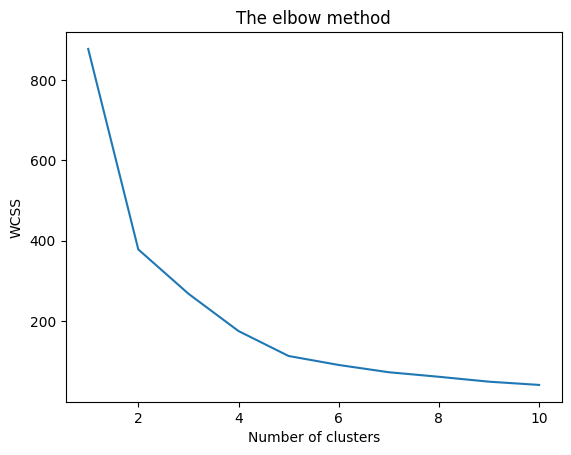

In [108]:
# Elbow mechanism
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [109]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(df_features)
df['cluster'] = y_kmeans

In [113]:
# Dataframe to Excel
df.to_excel("/content/ResearchArxivACM/analysis/out/merged_filtered_cluster_df.xlsx")

# Safe Dataframe to pickle
df.to_pickle("/content/ResearchArxivACM/analysis/out/merged_filtered_cluster_df.pkl")

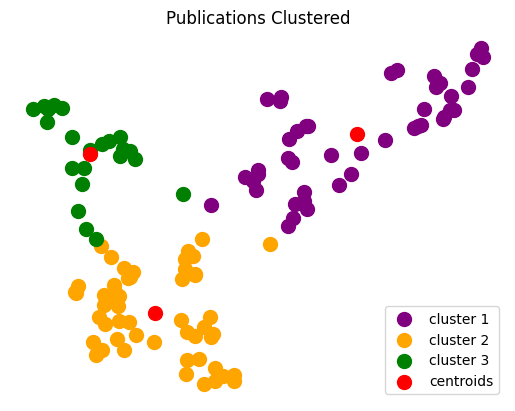

In [114]:
#Visualising the clusters
plt.scatter(df_features[y_kmeans == 0, 0], df_features[y_kmeans == 0, 1], s = 100, c = 'purple', label = 'cluster 1')
plt.scatter(df_features[y_kmeans == 1, 0], df_features[y_kmeans == 1, 1], s = 100, c = 'orange', label = 'cluster 2')
plt.scatter(df_features[y_kmeans == 2, 0], df_features[y_kmeans == 2, 1], s = 100, c = 'green', label = 'cluster 3')


#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'red', label = 'centroids')

plt.legend()
plt.axis("off")

plt.title("Publications Clustered")
# Save seaborn plot as image
plt.savefig('/content/ResearchArxivACM/analysis/out/abstracts_cluster_kmeans.png', dpi=300)

In [119]:
import plotly.graph_objects as go

# Create a scatter trace for each cluster
trace1 = go.Scatter(
    x=df[df['cluster'] == 0]['abstract_vector_d1'],
    y=df[df['cluster'] == 0]['abstract_vector_d2'],
    mode='markers',
    marker=dict(color='purple'),
    name='cluster1',
    customdata=[df["title"]]
)

trace2 = go.Scatter(
    x=df[df['cluster'] == 1]['abstract_vector_d1'],
    y=df[df['cluster'] == 1]['abstract_vector_d2'],
    mode='markers',
    marker=dict(color='orange'),
    name='cluster2',
    customdata=[df["title"]]
)

trace3 = go.Scatter(
    x=df[df['cluster'] == 2]['abstract_vector_d1'],
    y=df[df['cluster'] == 2]['abstract_vector_d2'],
    mode='markers',
    marker=dict(color='green'),
    name='cluster3',
    customdata=[df["title"]]
)


# Create a scatter trace for the centroids
centroid_trace = go.Scatter(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    mode='markers',
    marker=dict(color='red'),
    name='Centroids'
)

# Create the layout
layout = go.Layout(
    showlegend=True,
    autosize=False,
    width=1000,
    height=700
)


# Create the figure and add the traces
fig = go.Figure(data=[trace1, trace2, trace3, centroid_trace], layout=layout)

# Show the figure
fig.show()

In [126]:
import plotly.express as px
fig = px.scatter_3d(df, x="abstract_vector_d3",
                    y="abstract_vector_d2",
                    z="abstract_vector_d1",
                    color="cluster",
                    custom_data=["title", "year", "authors"] )


fig.update_traces(
    hovertemplate="<br>".join([
        "Title: %{customdata[0]}",
        "Year: %{customdata[1]}",
        "Authors: %{customdata[2]}",
    ])
)


fig.update_layout(
    autosize=True,
    width=1000,
    height=700,
    scene=dict(
        xaxis_title='Dimension 3',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 1'
    ),
    title={'text': 'Publications Clustered','x':0.5}
)

fig.show()

# Save seaborn plot as image
plt.savefig('/content/ResearchArxivACM/analysis/out/abstracts_cluster_plotly_adapted.png', dpi=300)

<Figure size 640x480 with 0 Axes>